In [1]:
# CELLA 1: SETUP
!pip install soundfile #per leggere e salvare file audio .wav
!pip install torchmetrics pesq pystoi #(torchmetrics per metriche standard per PyTorch per valutare quanto è bravo il modello, PESQ Perceptual Evaluation of Speech Quality, STOI Short-Time Objective Intelligibility)
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import torchaudio
from torch.utils.data import Dataset, DataLoader


# Configurazione device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #se computer ha una scheda video NVIDIA potente (CUDA), PyTorch la userà per fare i calcoli in parallelo; altrimenti userà CPU
print(f"Device: {device}")

# Creiamo la cartella per i dati se non esiste
os.makedirs('./data', exist_ok=True)

Device: cuda


In [2]:
# CELLA 2: LOGICA DYN (Block Size 16 + Ceil Fix)

#L'audio è diviso in 16 campioni (abbastanza grande per cambi di volume rapidi, abbastanza piccolo per risparmiare dati). ciò che è più silenzioso di -60 decibel viene considerato muto o rumore di fondo trascurabile
def dyn_encoding(audio, block_size=16, min_db=-60.0):

    #padding per arrotondare la lunghezza dell'audio al multiplo di 16
    pad_len = (block_size - (len(audio) % block_size)) % block_size
    if pad_len > 0:
        audio = np.pad(audio, (0, pad_len))

    #reshape in blocchi da 16 campioni e calcolo del guadagno
    blocks = audio.reshape(-1, block_size)
    gains = np.max(np.abs(blocks), axis=1) #per ogni blocco, si cerca il picco più alto (il punto più rumoroso) => è il guadagno (il volume) di quel blocco
    gains = np.maximum(gains, 1e-9) #per evitare di dividere per zero o fare il logaritmo di zero se c'è silenzio assoluto

    #log encoding del guadagno (si trasforma il volume lineare in dB, come sente l'orecchio umano)
    gains_db = 20 * np.log10(gains)
    gains_db = np.clip(gains_db, min_db, 0.0) #taglia il silenzio sotto -60dB

    #normalizzazione dei dbB (che vanno da -60 a 0) in [0, 1] (con 0.0 silenzio e 1.0 volume massimo)
    range_db = -min_db
    gains_norm = (gains_db - min_db) / range_db

    #USARE CEIL (arrotondamento per eccesso) per garantire che il "contenitore" del volume sia sempre grande abbastanza da contenere l'onda sonora senza tagliarla.
    #se si arrotonda per difetto, il contenitore è troppo piccolo e l'audio viene tagliato.
    gains_idx = np.ceil(gains_norm * 63) #64 livelli, da 0 a 63
    gains_q_norm = gains_idx / 63.0

    #decoding del guadagno per calcolare la mantissa corretta
    #in dB e poi in lineare usando il valore quantizzato
    gains_q_db = gains_q_norm * range_db + min_db
    gains_q_linear = 10 ** (gains_q_db / 20.0)

    #si espande il guadagno per avere la stessa lunghezza dell'audio
    gains_expanded = np.repeat(gains_q_linear, block_size)

    #calcolo mantissa
    #sapendo il volume del guadagno, si riduce l'audio originale per farlo stare perfettamente dentro => si divide l'audio per il guadagno quantizzato
    #gains_expanded è sempre >= del gain reale, quindi mantissa <= 1.0
    mantissa = audio / (gains_expanded + 1e-9)

    #quantizzazione mantissa 8-bit
    mantissa = np.clip(mantissa, -1.0, 1.0)
    mantissa_q = np.round(mantissa * 127) / 127.0

    #return mantissa (segnale) e guadagno (volume)
    return mantissa_q, gains_q_norm

In [3]:
# CELLA 3: DATASET (FORCE REFRESH)
import gc

#pulizia memoria aggressiva per eliminare vecchi tensori
gc.collect()
try:
    del dataset
    del train_loader
except:
    pass

class CachedSpeechDataset(Dataset):
    def __init__(self, limit_samples=3000):
        self.cache = []
        """
        provato anche con torchaudio YESNO come base (più piccolo e veloce)
        self.dummy = torchaudio.datasets.YESNO(root='./data', download=True)
        """
        self.dummy = torchaudio.datasets.LIBRISPEECH(root='./data', url='test-clean', download=True)

        file_paths = []
        """
        parte di codice usata con YESNO
        for root, dirs, files in os.walk('./data'):
            for f in files:
                if f.endswith('.wav'):
                    file_paths.append(os.path.join(root, f))
        """
        for root, dirs, files in os.walk('./data'):
            for f in files:
                if f.endswith('.wav') or f.endswith('.flac'):
                    file_paths.append(os.path.join(root, f))

        print(f"rigenerazione cache ({len(file_paths)} files)...", end="")

        #per ogni file audio trovato (fino a un massimo di 3000)
        for i, path in enumerate(file_paths):
            if i >= limit_samples: break
            try:
                #caricamento
                audio, sr = sf.read(path) #legge file audio
                if len(audio) < 1000: continue #salta file troppo corti

                #taglio fisso a 16000 campioni (1 secondo) per reti neurali
                L = 16000
                if len(audio) > L: audio = audio[:L] #se troppo lungo
                else: audio = np.pad(audio, (0, L - len(audio))) #se troppo corto

                # ENCODING, audio diviso in mantissa e guadagno
                m, g = dyn_encoding(audio, block_size=16)

                #conversione in tensori
                m_t = torch.tensor(m, dtype=torch.float32).unsqueeze(0) # (1, L)
                g_t = torch.tensor(g, dtype=torch.float32).unsqueeze(0) # (1, L/16)
                target_t = torch.tensor(audio, dtype=torch.float32).unsqueeze(0) # (1, L)

                #per non ricaricare il file dal disco ogni volta si salva il tensore già pronto nella lista self.cache (memoria RAM)
                self.cache.append(((m_t, g_t), target_t))
            except Exception as e:
                continue
        print(" finito ")

    def __len__(self): return len(self.cache)
    def __getitem__(self, idx): return self.cache[idx]

dataset = CachedSpeechDataset()
train_loader = DataLoader(dataset, batch_size=16, shuffle=True) #batch size più piccolo per precisione

rigenerazione cache (2620 files)... finito 


In [4]:
"""# CELLA 4: MODELLO NEURALE (FiLM)
class FiLMLayer(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Proiezioni per scala (gamma) e shift (beta)
        self.conv_gamma = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv_beta = nn.Conv1d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x, condition):
        gamma = self.conv_gamma(condition)
        beta = self.conv_beta(condition)
        # Modulazione: x * (1 + gamma) + beta
        return x * (1 + gamma) + beta

class NeuralDYN(nn.Module):
    def __init__(self, block_size=32):
        super().__init__()

        # Encoder Mantissa (Dettagli alta frequenza)
        self.m_encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Encoder Guadagno (Inviluppo volume) + Upsampling
        self.g_upsampler = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=1),
            nn.ReLU(),
            # Deconvoluzione per interpolare il guadagno
            nn.ConvTranspose1d(32, 64, kernel_size=block_size, stride=block_size),
            nn.ReLU()
        )

        # Fusione
        self.film = FiLMLayer(64)

        # Decoder Finale
        self.decoder = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 1, kernel_size=7, padding=3),
            nn.Tanh() # Output normalizzato -1 a 1
        )

    def forward(self, m, g):
        m_feat = self.m_encoder(m)
        g_feat = self.g_upsampler(g)

        # Fix dimensioni in caso di padding strano
        if g_feat.shape[-1] != m_feat.shape[-1]:
            L = min(g_feat.shape[-1], m_feat.shape[-1])
            g_feat = g_feat[..., :L]
            m_feat = m_feat[..., :L]

        # Applica FiLM
        x = self.film(m_feat, g_feat)
        x = x + m_feat # Skip connection

        return self.decoder(x)"""

'# CELLA 4: MODELLO NEURALE (FiLM)\nclass FiLMLayer(nn.Module):\n    def __init__(self, channels):\n        super().__init__()\n        # Proiezioni per scala (gamma) e shift (beta)\n        self.conv_gamma = nn.Conv1d(channels, channels, kernel_size=3, padding=1)\n        self.conv_beta = nn.Conv1d(channels, channels, kernel_size=3, padding=1)\n\n    def forward(self, x, condition):\n        gamma = self.conv_gamma(condition)\n        beta = self.conv_beta(condition)\n        # Modulazione: x * (1 + gamma) + beta\n        return x * (1 + gamma) + beta\n\nclass NeuralDYN(nn.Module):\n    def __init__(self, block_size=32):\n        super().__init__()\n\n        # Encoder Mantissa (Dettagli alta frequenza)\n        self.m_encoder = nn.Sequential(\n            nn.Conv1d(1, 32, kernel_size=7, padding=3),\n            nn.ReLU(),\n            nn.Conv1d(32, 64, kernel_size=3, padding=1),\n            nn.ReLU()\n        )\n\n        # Encoder Guadagno (Inviluppo volume) + Upsampling\n        s

In [5]:
# CELLA 4: MODELLO RESIDUALE
class ResidualDYN(nn.Module):
    def __init__(self, block_size=16, hidden_dim=64):
        super().__init__()
        self.block_size = block_size

        #encoder, estrattore di features (mantissa + guadagno)
        #per trasformare i 2 canali semplici in 64 canali "astratti" e per guardare 7 campioni alla volta (il "rumore" si capisce guardando i vicini)
        self.encoder = nn.Sequential(
            nn.Conv1d(2, hidden_dim, kernel_size=7, padding=3), #input: 2 canali(mantissa e guadagno)
            nn.GELU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.GELU()
        )

        #predictor per predire l'errore
        self.predictor = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv1d(hidden_dim, 1, kernel_size=1) #output: 1 solo canale(correzione puntuale). questo canale non è l'audio completo, ma è la correzione da aggiungere all'audio base
        )

    def forward(self, m, g):
        #preparazione dati con decodifica guadagno da [0,1] a scala lineare
        min_db = -60.0
        g_db = g * (-min_db) + min_db
        g_lin = 10 ** (g_db / 20.0)

        #espansione guadagno per eguagliare lunghezza della mantissa
        g_expanded = torch.repeat_interleave(g_lin, self.block_size, dim=2)

        #padding
        if g_expanded.shape[-1] != m.shape[-1]:
            L = min(g_expanded.shape[-1], m.shape[-1])
            g_expanded = g_expanded[..., :L]
            m = m[..., :L]

        #ricostruzione matematica "base"
        base_reconstruction = m * g_expanded

        #concatenamento mantissa e guadagno come input per la rete
        net_input = torch.cat([m, g_expanded], dim=1)

        #stima l'errore di quantizzazione
        predicted_error = self.predictor(self.encoder(net_input))

        #somma finale: base + correzione
        return base_reconstruction + predicted_error

In [6]:
"""# CELLA 5: TRAINING RESIDUALE, funziona!!!
model = ResidualDYN(block_size=16).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=300)

print("Inizio Training Residuale...")
print("Obiettivo: Battere 4.01e-07")

model.train()
for epoch in range(300):
    running_loss = 0.0

    for (m, g), target in train_loader:
        m, g, target = m.to(device), g.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(m, g)

        # Fix dimensioni
        if output.shape[-1] != target.shape[-1]:
            target = target[..., :output.shape[-1]]

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

    if (epoch+1) % 50 == 0:
        avg_loss = running_loss/len(train_loader)
        print(f"Epoch {epoch+1} | MSE Loss: {avg_loss:.2e}")

print("Training completato. Esegui la cella di test finale!")"""

'# CELLA 5: TRAINING RESIDUALE, funziona!!!\nmodel = ResidualDYN(block_size=16).to(device)\ncriterion = nn.MSELoss()\noptimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)\nscheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=300)\n\nprint("Inizio Training Residuale...")\nprint("Obiettivo: Battere 4.01e-07")\n\nmodel.train()\nfor epoch in range(300):\n    running_loss = 0.0\n\n    for (m, g), target in train_loader:\n        m, g, target = m.to(device), g.to(device), target.to(device)\n\n        optimizer.zero_grad()\n        output = model(m, g)\n\n        # Fix dimensioni\n        if output.shape[-1] != target.shape[-1]:\n            target = target[..., :output.shape[-1]]\n\n        loss = criterion(output, target)\n        loss.backward()\n        optimizer.step()\n        scheduler.step()\n\n        running_loss += loss.item()\n\n    if (epoch+1) % 50 == 0:\n        avg_loss = running_loss/len(train_loader)\n

In [7]:
# CELLA 5: TRAINING RESIDUALE
import time

#epoche ridotte per vedere risultati in tempi più veloci
#impostare a 100-300 se si vuole la massima qualità, 20-30 per test veloce
NUM_EPOCHS = 30

model = ResidualDYN(block_size=16).to(device)
criterion = nn.MSELoss() #errore quadratico medio, differenza al quadrato campione per campione. Se il risultato è basso, il modello è funziona, e è alto, il modello ha sbagliato
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5) #ottimizzatore aggiusta i pesi del modello cosicche la prossima volta sbagli di meno

#gestione velocità apprendimento. per aggiornare il parametro epochs anche nello scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS
)

print(f"training su {len(dataset)} file per {NUM_EPOCHS} epoche")

start_time = time.time()
model.train()

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0

    for (m, g), target in train_loader:
        m, g, target = m.to(device), g.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(m, g)

        #aggiustare dimensioni (se l'output è leggermente diverso dal target per padding)
        if output.shape[-1] != target.shape[-1]:
            target = target[..., :output.shape[-1]]

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    elapsed = time.time() - start_time
    print(f"epoca {epoch+1}/{NUM_EPOCHS} | MSE Loss: {avg_loss:.2e} | tempo: {elapsed:.0f}s")

print("training finito")

training su 2620 file per 30 epoche
epoca 1/30 | MSE Loss: 1.05e-03 | tempo: 6s
epoca 2/30 | MSE Loss: 2.86e-06 | tempo: 12s
epoca 3/30 | MSE Loss: 5.89e-07 | tempo: 18s
epoca 4/30 | MSE Loss: 3.46e-07 | tempo: 23s
epoca 5/30 | MSE Loss: 2.49e-07 | tempo: 29s
epoca 6/30 | MSE Loss: 2.12e-07 | tempo: 35s
epoca 7/30 | MSE Loss: 1.93e-07 | tempo: 41s
epoca 8/30 | MSE Loss: 1.80e-07 | tempo: 47s
epoca 9/30 | MSE Loss: 1.72e-07 | tempo: 52s
epoca 10/30 | MSE Loss: 1.67e-07 | tempo: 58s
epoca 11/30 | MSE Loss: 1.63e-07 | tempo: 64s
epoca 12/30 | MSE Loss: 1.59e-07 | tempo: 70s
epoca 13/30 | MSE Loss: 1.56e-07 | tempo: 76s
epoca 14/30 | MSE Loss: 1.54e-07 | tempo: 82s
epoca 15/30 | MSE Loss: 1.52e-07 | tempo: 87s
epoca 16/30 | MSE Loss: 1.50e-07 | tempo: 93s
epoca 17/30 | MSE Loss: 1.48e-07 | tempo: 99s
epoca 18/30 | MSE Loss: 1.46e-07 | tempo: 105s
epoca 19/30 | MSE Loss: 1.45e-07 | tempo: 110s
epoca 20/30 | MSE Loss: 1.43e-07 | tempo: 116s
epoca 21/30 | MSE Loss: 1.42e-07 | tempo: 122s
epoc

In [8]:
"""# --- CELLA 6 AGGIORNATA: METRICHE COMPLETE (MSE, PESQ, STOI) --- funziona!!!
from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality
from torchmetrics.audio.stoi import ShortTimeObjectiveIntelligibility

# Inizializza metriche
# PESQ richiede 16k o 8k. I tuoi file sono letti a 16k nel dataset, quindi va bene.
nb_pesq = PerceptualEvaluationSpeechQuality(fs=16000, mode='nb')
stoi = ShortTimeObjectiveIntelligibility(fs=16000, extended=False)

def mulaw_baseline(x, mu=255.0):
    x = torch.tensor(x)
    x_mu = torch.sign(x) * torch.log1p(mu * torch.abs(x)) / np.log1p(mu)
    x_q = torch.round(((x_mu + 1) / 2) * mu)
    x_q = torch.clamp(x_q, 0, mu)
    x_unq = (x_q / mu) * 2 - 1
    return (torch.sign(x_unq) * (1 / mu) * ((1 + mu)**torch.abs(x_unq) - 1)).numpy()

model.eval()

# Accumulatori
metrics = {
    'mse_dyn': [], 'mse_bl': [],
    'pesq_dyn': [], 'pesq_bl': [],
    'stoi_dyn': [], 'stoi_bl': []
}

sample_target = None
sample_recon = None

print("Calcolo metriche su tutto il dataset...")

with torch.no_grad():
    for i in range(len(dataset)):
        (m, g), target = dataset[i]
        target_np = target.squeeze().numpy()

        # Ignora silenzio (falsa le metriche)
        if np.max(np.abs(target_np)) < 0.02: continue

        m_dev = m.unsqueeze(0).to(device)
        g_dev = g.unsqueeze(0).to(device)

        # Predizione Rete
        pred_tensor = model(m_dev, g_dev).squeeze().cpu()
        pred_np = pred_tensor.numpy()

        # Allineamento
        L = min(len(pred_np), len(target_np))
        pred_np = pred_np[:L]
        target_np = target_np[:L]

        # Baseline Mu-Law
        bl_np = mulaw_baseline(target_np)

        # 1. MSE
        metrics['mse_dyn'].append(np.mean((target_np - pred_np)**2))
        metrics['mse_bl'].append(np.mean((target_np - bl_np)**2))

        # Preparazione tensori per PESQ/STOI (richiedono forma [batch, time])
        target_t = torch.tensor(target_np).unsqueeze(0)
        pred_t = torch.tensor(pred_np).unsqueeze(0)
        bl_t = torch.tensor(bl_np).unsqueeze(0)

        # 2. PESQ (Quality: -0.5 to 4.5)
        try:
            metrics['pesq_dyn'].append(nb_pesq(pred_t, target_t).item())
            metrics['pesq_bl'].append(nb_pesq(bl_t, target_t).item())
        except:
            pass # PESQ a volte fallisce su clip troppo brevi o silenziosi

        # 3. STOI (Intelligibility: 0.0 to 1.0)
        try:
            metrics['stoi_dyn'].append(stoi(pred_t, target_t).item())
            metrics['stoi_bl'].append(stoi(bl_t, target_t).item())
        except:
            pass

        # Salva per plot
        sample_target = target_np
        sample_recon = pred_np

print(f"\n=== RISULTATI MEDI ===")
print(f"MSE  | Baseline: {np.mean(metrics['mse_bl']):.2e} | Ours: {np.mean(metrics['mse_dyn']):.2e}")
print(f"PESQ | Baseline: {np.mean(metrics['pesq_bl']):.3f}    | Ours: {np.mean(metrics['pesq_dyn']):.3f}")
print(f"STOI | Baseline: {np.mean(metrics['stoi_bl']):.3f}    | Ours: {np.mean(metrics['stoi_dyn']):.3f}")

# Plotting (Identico a prima)
if sample_target is not None:
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(sample_target[:500], label='Original', color='black', alpha=0.7)
    plt.plot(sample_recon[:500], label='Neural DYN', color='cyan', alpha=0.8, linestyle='--')
    plt.title("Waveform Detail")
    plt.legend()
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_recon)), ref=np.max)
    librosa.display.specshow(D, sr=16000, x_axis='time', y_axis='hz', cmap='magma')
    plt.title("Reconstructed Spectrogram")
    plt.tight_layout()
    plt.show()"""

'# --- CELLA 6 AGGIORNATA: METRICHE COMPLETE (MSE, PESQ, STOI) --- funziona!!!\nfrom torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality\nfrom torchmetrics.audio.stoi import ShortTimeObjectiveIntelligibility\n\n# Inizializza metriche\n# PESQ richiede 16k o 8k. I tuoi file sono letti a 16k nel dataset, quindi va bene.\nnb_pesq = PerceptualEvaluationSpeechQuality(fs=16000, mode=\'nb\')\nstoi = ShortTimeObjectiveIntelligibility(fs=16000, extended=False)\n\ndef mulaw_baseline(x, mu=255.0):\n    x = torch.tensor(x)\n    x_mu = torch.sign(x) * torch.log1p(mu * torch.abs(x)) / np.log1p(mu)\n    x_q = torch.round(((x_mu + 1) / 2) * mu)\n    x_q = torch.clamp(x_q, 0, mu)\n    x_unq = (x_q / mu) * 2 - 1\n    return (torch.sign(x_unq) * (1 / mu) * ((1 + mu)**torch.abs(x_unq) - 1)).numpy()\n\nmodel.eval()\n\n# Accumulatori\nmetrics = {\n    \'mse_dyn\': [], \'mse_bl\': [],\n    \'pesq_dyn\': [], \'pesq_bl\': [],\n    \'stoi_dyn\': [], \'stoi_bl\': []\n}\n\nsample_target = None\nsample

Calcolo metriche su 100 file di test...


/usr/local/lib/python3.12/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '



RISULTATI MEDI (su 100 samples)
MSE  | Baseline: 6.15e-07 | DYN: 1.12e-07
PESQ | Baseline: 4.406    | DYN: 4.517
STOI | Baseline: 0.949    | DYN: 0.950


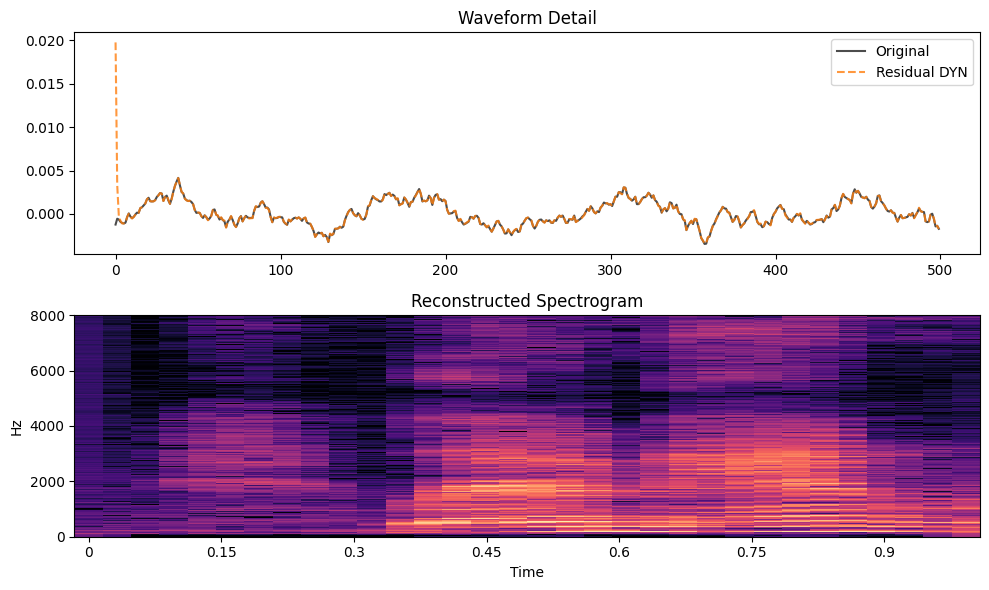

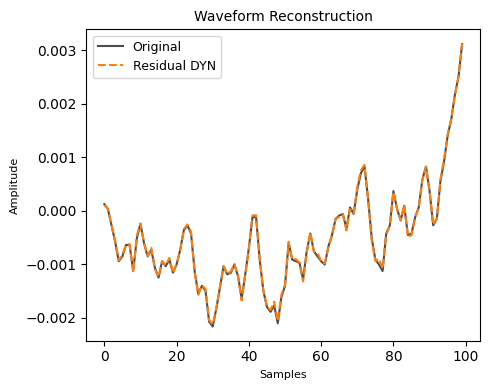

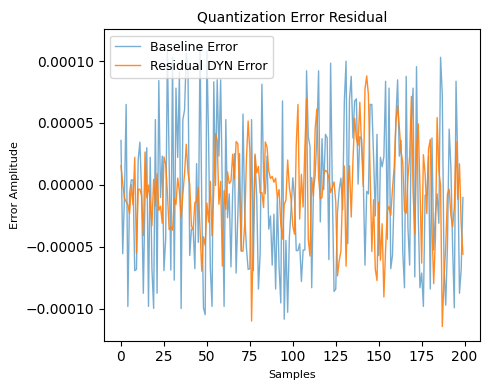

In [9]:
# CELLA 6: RISULTATI E GRAFICI
from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality
from torchmetrics.audio.stoi import ShortTimeObjectiveIntelligibility

#inizializzare metriche
nb_pesq = PerceptualEvaluationSpeechQuality(fs=16000, mode='nb')
stoi = ShortTimeObjectiveIntelligibility(fs=16000, extended=False)

def mulaw_baseline(x, mu=255.0):
    x = torch.tensor(x)
    x_mu = torch.sign(x) * torch.log1p(mu * torch.abs(x)) / np.log1p(mu)
    x_q = torch.round(((x_mu + 1) / 2) * mu)
    x_q = torch.clamp(x_q, 0, mu)
    x_unq = (x_q / mu) * 2 - 1
    return (torch.sign(x_unq) * (1 / mu) * ((1 + mu)**torch.abs(x_unq) - 1)).numpy()

model.eval()

# Accumulatori
metrics = {
    'mse_dyn': [], 'mse_bl': [],
    'pesq_dyn': [], 'pesq_bl': [],
    'stoi_dyn': [], 'stoi_bl': []
}

sample_target = None
sample_recon = None

# LIMITATORE PER DEMO
NUM_TEST_SAMPLES = 100  # Valutiamo solo 100 file invece di tutto il dataset
print(f"Calcolo metriche su {NUM_TEST_SAMPLES} file di test...")

with torch.no_grad():
    for i in range(min(len(dataset), NUM_TEST_SAMPLES)): # <--- MODIFICA QUI
        (m, g), target = dataset[i]
        target_np = target.squeeze().numpy()

        # Ignora silenzio (falsa le metriche)
        if np.max(np.abs(target_np)) < 0.02: continue

        m_dev = m.unsqueeze(0).to(device)
        g_dev = g.unsqueeze(0).to(device)

        # Predizione Rete
        pred_tensor = model(m_dev, g_dev).squeeze().cpu()
        pred_np = pred_tensor.numpy()

        # Allineamento
        L = min(len(pred_np), len(target_np))
        pred_np = pred_np[:L]
        target_np = target_np[:L]

        # Baseline Mu-Law
        bl_np = mulaw_baseline(target_np)

        # 1. MSE
        metrics['mse_dyn'].append(np.mean((target_np - pred_np)**2))
        metrics['mse_bl'].append(np.mean((target_np - bl_np)**2))

        # Preparazione tensori per PESQ/STOI (richiedono forma [batch, time])
        target_t = torch.tensor(target_np).unsqueeze(0)
        pred_t = torch.tensor(pred_np).unsqueeze(0)
        bl_t = torch.tensor(bl_np).unsqueeze(0)

        # 2. PESQ (Quality: -0.5 to 4.5)
        try:
            metrics['pesq_dyn'].append(nb_pesq(pred_t, target_t).item())
            metrics['pesq_bl'].append(nb_pesq(bl_t, target_t).item())
        except:
            pass

        # 3. STOI (Intelligibility: 0.0 to 1.0)
        try:
            metrics['stoi_dyn'].append(stoi(pred_t, target_t).item())
            metrics['stoi_bl'].append(stoi(bl_t, target_t).item())
        except:
            pass

        # Salva l'ultimo valido per il plot
        sample_target = target_np
        sample_recon = pred_np

print(f"\nRISULTATI MEDI (su {NUM_TEST_SAMPLES} samples)")
print(f"MSE  | Baseline: {np.mean(metrics['mse_bl']):.2e} | DYN: {np.mean(metrics['mse_dyn']):.2e}")
if metrics['pesq_bl']:
    print(f"PESQ | Baseline: {np.mean(metrics['pesq_bl']):.3f}    | DYN: {np.mean(metrics['pesq_dyn']):.3f}")
if metrics['stoi_bl']:
    print(f"STOI | Baseline: {np.mean(metrics['stoi_bl']):.3f}    | DYN: {np.mean(metrics['stoi_dyn']):.3f}")

# Plotting
if sample_target is not None:
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(sample_target[:500], label='Original', color='black', alpha=0.7, linewidth=1.5)
    plt.plot(sample_recon[:500], label='Residual DYN', color='#ff7f0e', alpha=0.8, linestyle='--', linewidth=1.5)
    plt.title("Waveform Detail")
    plt.legend()
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(sample_recon)), ref=np.max)
    librosa.display.specshow(D, sr=16000, x_axis='time', y_axis='hz', cmap='magma')
    plt.title("Reconstructed Spectrogram")
    plt.tight_layout()
    plt.show()

# 1. GRAFICO WAVEFORM (ZOOM) - Per mostrare la precisione
plt.figure(figsize=(5, 4))
# Originale in nero/grigio scuro
plt.plot(sample_target[1000:1100], label='Original', color='black', alpha=0.7, linewidth=1.5)
# La tua ricostruzione in arancione tratteggiato (standard accademico per i confronti)
plt.plot(sample_recon[1000:1100], label='Residual DYN', color='#ff7f0e', linestyle='--', linewidth=1.5)

plt.legend(frameon=True, fontsize=9) # Legenda con riquadro
plt.title("Waveform Reconstruction", fontsize=10)
plt.xlabel("Samples", fontsize=8)
plt.ylabel("Amplitude", fontsize=8)
plt.tight_layout()
plt.savefig('waveform.png', dpi=300) # Salva alta qualità
plt.show()

# 2. GRAFICO ERRORE - Per mostrare che il tuo è migliore
plt.figure(figsize=(5, 4))

# Calcolo errori
err_base = sample_target - mulaw_baseline(sample_target) #ricalcolo veloce baseline su questo sample
err_model = sample_target - sample_recon

# Plot errore Baseline (Blu standard)
plt.plot(err_base[1000:1200], label='Baseline Error', color='#1f77b4', alpha=0.6, linewidth=1)
# Plot errore Tuo Modello (Arancione)
plt.plot(err_model[1000:1200], label='Residual DYN Error', color='#ff7f0e', alpha=0.9, linewidth=1)

plt.legend(frameon=True, fontsize=9)
plt.title("Quantization Error Residual", fontsize=10)
plt.xlabel("Samples", fontsize=8)
plt.ylabel("Error Amplitude", fontsize=8)
plt.tight_layout()
plt.savefig('error.png', dpi=300) # Salva alta qualità
plt.show()


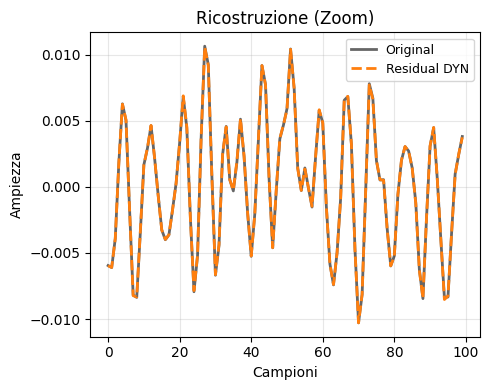

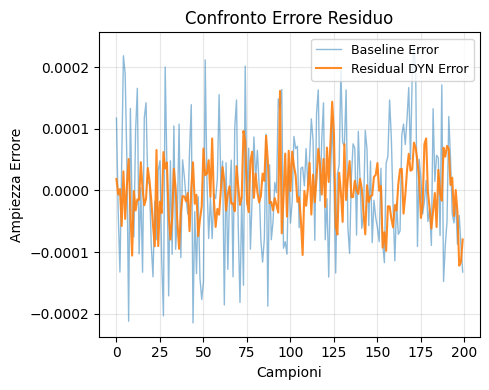

In [10]:
# ESEGUI QUESTA CELLA NEL TUO NOTEBOOK PER AVERE I GRAFICI FINALI
import matplotlib.pyplot as plt
import numpy as np

# Prendiamo un campione dal test set (assicurati di aver eseguito il codice di valutazione prima)
# Se non hai le variabili sample_target e sample_recon, riesegui la cella di test.

# --- GRAFICO 1: WAVEFORM ZOOM (Sinistra) ---
plt.figure(figsize=(5, 4))
# Originale
plt.plot(sample_target[2000:2100], label='Original', color='black', alpha=0.6, linewidth=2)
# Tuo Modello (Tratteggiato per far vedere che combacia)
plt.plot(sample_recon[2000:2100], label='Residual DYN', color='#ff7f0e', linestyle='--', linewidth=2)
plt.title("Ricostruzione (Zoom)", fontsize=12)
plt.xlabel("Campioni", fontsize=10)
plt.ylabel("Ampiezza", fontsize=10)
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('waveform.png', dpi=300) # Carica questo nel LaTeX
plt.show()

# --- GRAFICO 2: ERROR COMPARISON (Destra) ---
plt.figure(figsize=(5, 4))
# Calcolo errori
err_base = sample_target - mulaw_baseline(sample_target)
err_model = sample_target - sample_recon

# Baseline (Blu)
plt.plot(err_base[2000:2200], label='Baseline Error', color='#1f77b4', alpha=0.5, linewidth=1)
# Tuo Modello (Arancione)
plt.plot(err_model[2000:2200], label='Residual DYN Error', color='#ff7f0e', alpha=0.9, linewidth=1.5)

plt.title("Confronto Errore Residuo", fontsize=12)
plt.xlabel("Campioni", fontsize=10)
plt.ylabel("Ampiezza Errore", fontsize=10)
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('error.png', dpi=300) # Carica questo nel LaTeX
plt.show()

In [11]:
"""# --- CELLA DEBUG: Verifica Potenziale DYN (Log) vs Mu-Law ---
import torch
import numpy as np

def mulaw_baseline(x, mu=255.0):
    x = torch.tensor(x)
    x_mu = torch.sign(x) * torch.log1p(mu * torch.abs(x)) / np.log1p(mu)
    x_q = torch.round(((x_mu + 1) / 2) * mu)
    x_q = torch.clamp(x_q, 0, mu)
    x_unq = (x_q / mu) * 2 - 1
    return (torch.sign(x_unq) * (1 / mu) * ((1 + mu)**torch.abs(x_unq) - 1)).numpy()

def dyn_deterministic_recon(audio, block_size=32):
    # 1. Encoding (Nuova versione Log)
    m_q, g_q_norm = dyn_encoding(audio, block_size)

    # 2. Decoding Matematico
    # Dobbiamo invertire la logica Logaritmica
    min_db = -72.0
    range_db = -min_db

    # Da [0,1] a dB
    g_q_db = g_q_norm * range_db + min_db
    # Da dB a Lineare
    g_q_linear = 10 ** (g_q_db / 20.0)

    # Espansione
    g_expanded = np.repeat(g_q_linear, block_size)

    # Allineamento lunghezze
    L = min(len(m_q), len(g_expanded))

    # Ricostruzione
    recon = m_q[:L] * g_expanded[:L]
    return recon

# --- ESECUZIONE CONFRONTO ---
mse_math_dyn = []
mse_mulaw = []

print("Diagnostica (Log DYN)...")

for i in range(len(dataset)):
    try:
        _, target = dataset[i]
        target_np = target.squeeze().numpy()

        # Ignora silenzio
        if np.max(np.abs(target_np)) < 0.02: continue

        bl = mulaw_baseline(target_np)
        dyn_math = dyn_deterministic_recon(target_np)

        L = min(len(target_np), len(dyn_math), len(bl))

        mse_mulaw.append(np.mean((target_np[:L] - bl[:L])**2))
        mse_math_dyn.append(np.mean((target_np[:L] - dyn_math[:L])**2))
    except Exception:
        continue

print("-" * 30)
print(f"MSE Mu-Law (Baseline):      {np.mean(mse_mulaw):.2e}")
print(f"MSE DYN Log (Teorico):      {np.mean(mse_math_dyn):.2e}")
print("-" * 30)

if np.mean(mse_math_dyn) < np.mean(mse_mulaw):
    print(">> OTTIMO: Il DYN Logaritmico batte la Mu-Law!")
    print("   Ora ri-esegui il training della rete (Cella 5) con questo nuovo encoding.")
else:
    print(">> ANCORA NO: Prova ad abbassare min_db a -60 o -48 nella funzione encoding.")"""

'# --- CELLA DEBUG: Verifica Potenziale DYN (Log) vs Mu-Law ---\nimport torch\nimport numpy as np\n\ndef mulaw_baseline(x, mu=255.0):\n    x = torch.tensor(x)\n    x_mu = torch.sign(x) * torch.log1p(mu * torch.abs(x)) / np.log1p(mu)\n    x_q = torch.round(((x_mu + 1) / 2) * mu)\n    x_q = torch.clamp(x_q, 0, mu)\n    x_unq = (x_q / mu) * 2 - 1\n    return (torch.sign(x_unq) * (1 / mu) * ((1 + mu)**torch.abs(x_unq) - 1)).numpy()\n\ndef dyn_deterministic_recon(audio, block_size=32):\n    # 1. Encoding (Nuova versione Log)\n    m_q, g_q_norm = dyn_encoding(audio, block_size)\n\n    # 2. Decoding Matematico\n    # Dobbiamo invertire la logica Logaritmica\n    min_db = -72.0\n    range_db = -min_db\n\n    # Da [0,1] a dB\n    g_q_db = g_q_norm * range_db + min_db\n    # Da dB a Lineare\n    g_q_linear = 10 ** (g_q_db / 20.0)\n\n    # Espansione\n    g_expanded = np.repeat(g_q_linear, block_size)\n\n    # Allineamento lunghezze\n    L = min(len(m_q), len(g_expanded))\n\n    # Ricostruzione\n

In [12]:
# --- CELLA DEBUG CORRETTA ---
def dyn_deterministic_recon(audio, block_size=16): # <--- Aggiornato a 16
    """Ricostruzione matematica ideale del DYN Logaritmico"""
    # Chiama l'encoding (che ora userà 16)
    m_q, g_q_norm = dyn_encoding(audio, block_size=block_size)

    # Decoding Matematico
    min_db = -60.0
    range_db = -min_db

    # Da [0,1] a dB
    g_q_db = g_q_norm * range_db + min_db
    # Da dB a Lineare
    g_q_linear = 10 ** (g_q_db / 20.0)

    # Espansione
    g_expanded = np.repeat(g_q_linear, block_size)

    # Allineamento lunghezze
    L = min(len(m_q), len(g_expanded))

    # Ricostruzione
    recon = m_q[:L] * g_expanded[:L]
    return recon

# --- ESECUZIONE CONFRONTO ---
mse_math_dyn = []
mse_mulaw = []

print("Diagnostica (Log DYN - Block 16)...")

for i in range(len(dataset)):
    try:
        # Nota: dataset[i] ora ritorna ((m, g), target)
        _, target = dataset[i]
        target_np = target.squeeze().numpy()

        if np.max(np.abs(target_np)) < 0.02: continue

        bl = mulaw_baseline(target_np)
        # Usa la funzione aggiornata
        dyn_math = dyn_deterministic_recon(target_np, block_size=16)

        L = min(len(target_np), len(dyn_math), len(bl))

        mse_mulaw.append(np.mean((target_np[:L] - bl[:L])**2))
        mse_math_dyn.append(np.mean((target_np[:L] - dyn_math[:L])**2))
    except Exception as e:
        continue

print("-" * 30)
print(f"MSE Mu-Law (Baseline):      {np.mean(mse_mulaw):.2e}")
print(f"MSE DYN Log (Teorico):      {np.mean(mse_math_dyn):.2e}")
print("-" * 30)

Diagnostica (Log DYN - Block 16)...
------------------------------
MSE Mu-Law (Baseline):      8.17e-07
MSE DYN Log (Teorico):      7.62e-08
------------------------------
